<a href="https://colab.research.google.com/github/SriSatyaLokesh/some-app-for-whatsapp/blob/master/notebooks/analytics/word_cloud-satya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving WhatsApp Chat with CSE 2K16-2K20.txt to WhatsApp Chat with CSE 2K16-2K20.txt


In [3]:
import pandas as pd
from itertools import chain, repeat
from string import digits
import re

chainer = chain.from_iterable
class Cleaner:
  def __init__(self,filename):
    self.filename = filename

  def _clean_data(self):
    """ 
    What it does?
    ----------------
      remove action messages and append new line without date format to previous message
      
      EXAMPLE : 
      17/07/19, 8:33 pm - +91 90633 88499: Sir,
      *We have a chance to write Cocubes exam later...?*
      CHANGED TO:
      17/07/19, 8:33 pm - +91 90633 88499: Sir, *We have a chance to write Cocubes exam later...?*
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      raw_texts : list
                  list consists of all raw messages ignoring actions from the chat file
      
    """
    chat_file = self.filename
    with open(chat_file) as file:
      all_msgs = file.readlines()
      raw_texts = []
      for line in all_msgs:
        if re.match("^\d{2}/\d{2}/\d{2,4},\s\d{1,2}:\d{2}\s[ap]*[m]*",line):
          date_split = line.split(' - ') 
          user_split = date_split[1].split(':')
          if len(user_split) >= 2:
            raw_texts.append(line)
        else:
          try:
            raw_texts[-1] += line
          except Exception as err:
            print(line,raw_texts)
            print(err)

    return raw_texts 
      
  def _get_data(self):
    """ 
    What it does?
    ----------------
      Import whatsapp data and transform it to a dataframe
      
      Parameters:
      -----------
      -
          
      Returns:
      --------
      df : dataframe
          Dataframe of all messages with columns - ["users", "raw_text"]
      
    """
    raw_texts = self._clean_data()
    raw_messages = dict()
    for line in raw_texts:
      date_split = line.split(' - ')
      user_split = date_split[1].split(':')
      user = user_split[0]
      if user not in raw_messages:
        raw_messages[user] = [line]
      else:
        raw_messages[user].append(line)
    df = pd.DataFrame({'user': list(chainer(repeat(k, len(v)) for k,v in raw_messages.items())),
                   'raw_text': list(chainer(raw_messages.values()))}) 
    return df

  def _get_message(self,df):
    """ 
    What it does?
    ----------------
      new column is added to existing dataframe i.e clean_message which ignores datetime and user from the raw_message
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      df : dataframe
          Dataframe of all messages with columns - ["users", "raw_text", "raw_message",]
      
    """
    df["raw_message"] = df.apply(lambda df : "".join(df['raw_text'].split(":")[2:]),axis=1)
    df["raw_message"] = df.apply(lambda df : df['raw_message'][:-1],axis=1)
    return df

  def _get_text_only_message(self,df):
    """ 
    What it does?
    ----------------
      new column is added to existing dataframe i.e text_only_message which ignores all emojis and numbers from the clean_message
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      df : dataframe
          Dataframe of all messages with columns - ["users", "raw_text", "raw_message", "text_only_message"]
      
    """
    remove_digits = str.maketrans('', '', digits)
    df["text_only_message"] = df.apply(lambda df : df["raw_message"].encode('ascii', 'ignore').decode('ascii'),axis=1)     # removing emoji s from cleam_message
    df["text_only_message"] = df.apply(lambda df : df["text_only_message"].translate(remove_digits),axis=1)          # removing digits from clean_message

    df.loc[(df['text_only_message'] == " This message was deleted") | (df['text_only_message'] == " <Media omitted>"),'text_only_message'] = "" # updating "This message was deleted" & "media" to ""(empty_string)

    return df

  def _remove_inactive_users(self,df):
    """ 
    What it does?
    ----------------
      removes inactive users i.e user with no of messages < 10 from dataframe
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      df : dataframe
          Dataframe of all messages with columns - ["users", "raw_text", "raw_message", "text_only_message"]
          removing inactive users
      
    """
    df = df.groupby('user').filter(lambda x : len(x) > 10)
    return df

  def _get_user_media_counts(self,df):
    """ 
    What it does?
    ----------------
      it counts individual user media that is sent in the chat
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      user_media_counts : dictionary
                          key as 'user' : value as 'media_count'
      
    """
    media_count = df[df['raw_message'] == " <Media omitted>"].groupby('user').size()
    user_media_counts = media_count.to_dict()
    return user_media_counts

  def _get_datetime(self,df):
    """ 
    What it does?
    ----------------
      3 columns are added i.e 
      
      1. "date" : datetime from raw_text
      2. "hour" : Hour from date column
      3. "weekday" : day of the week from date column 
      
      Parameters:
      -----------
      df : dataframe
          
      Returns:
      --------
      df : dataframe
          Dataframe with only active user messages with columns - ["users", "raw_text", "raw_message", "text_only_message", "date", "hour", "weekday"]
      
    """

    df['date'] =  df.apply(lambda df : df['raw_text'].split(" - ")[0],axis=1)

    temp = ["%d/%m/%Y, %I:%M %p" , "%d/%m/%y, %I:%M %p" , "%d/%m/%Y, %H:%M" , "%d/%m/%y, %H:%M" ,
        "%d/%Y/%m, %I:%M %p" , "%d/%y/%m, %I:%M %p" , "%d/%Y/%m, %H:%M" , "%d/%y/%m, %H:%M" ,
        "%Y/%m/%d, %I:%M %p" , "%y/%m/%d, %I:%M %p" , "%Y/%m/%d, %H:%M" , "%y/%m/%d, %H:%M" ,
        "%Y/%d/%m, %I:%M %p" , "%y/%d/%m, %I:%M %p" , "%Y/%d/%m, %H:%M" , "%y/%d/%m, %H:%M" ,
        "%m/%Y/%d, %I:%M %p" , "%m/%y/%d, %I:%M %p" , "%m/%Y/%d, %H:%M" , "%m/%y/%d, %H:%M" ,
        "%m/%d/%Y, %I:%M %p" , "%m/%d/%y, %I:%M %p" , "%m/%d/%Y, %H:%M" , "%m/%d/%y, %H:%M"]

    for formats in temp:       
      try:
        df['date'] = pd.to_datetime(df['date'], format=formats)
      except:
        continue
    df['hour'] = df['date'].dt.hour
    df['weekday'] = df['date'].dt.weekday
    
    return df

chat_file = 'WhatsApp Chat with CSE 2K16-2K20.txt'
clean = Cleaner(chat_file)
df = clean._get_data()
df = clean._get_message(df)
df = clean._get_text_only_message(df)
df = clean._remove_inactive_users(df)
df = clean._get_datetime(df)
df

,user,raw_text,raw_message,text_only_message,date,hour,weekday
0,+91 81432 75536,"12/10/2019, 11:21 am - +91 81432 75536: Remain...",Remainder,Remainder,2019-10-12 11:21:00,11,5
1,+91 81432 75536,"25/10/2019, 3:30 pm - +91 81432 75536: <Media ...",<Media omitted>,,2019-10-25 15:30:00,15,4
2,+91 81432 75536,"25/10/2019, 3:30 pm - +91 81432 75536: <Media ...",<Media omitted>,,2019-10-25 15:30:00,15,4
3,+91 81432 75536,"25/10/2019, 3:33 pm - +91 81432 75536: Dear st...",Dear students these are shortlisted candidate...,Dear students these are shortlisted candidate...,2019-10-25 15:33:00,15,4
4,+91 81432 75536,"25/10/2019, 3:38 pm - +91 81432 75536: The sho...",The shortlisted students for Hitachi consulti...,The shortlisted students for Hitachi consulti...,2019-10-25 15:38:00,15,4
...,...,...,...,...,...,...,...
318,+91 99126 48686,"15/04/2020, 10:19 am - +91 99126 48686: Guys l...",Guys last 2 minutes,Guys last minutes,2020-04-15 10:19:00,10,2
319,+91 99126 48686,"15/04/2020, 10:19 am - +91 99126 48686: Exam w...",Exam will closes,Exam will closes,2020-04-15 10:19:00,10,2
320,+91 99126 48686,"15/04/2020, 10:30 am - +91 99126 48686: <Media...",<Media omitted>,,2020-04-15 10:30:00,10,2
321,+91 99126 48686,"15/04/2020, 10:38 am - +91 99126 48686: <Media...",<Media omitted>,,2020-04-15 10:38:00,10,2


[For Reference](https://stackoverflow.com/questions/46786211/counting-the-frequency-of-words-in-a-pandas-data-frame)

In [6]:
frequent_words = pd.Series(' '.join(df.text_only_message).split()).value_counts()[:50]
frequent_words

the            106
students        69
to              66
and             64
for             60
are             39
of              39
will            39
you             36
.               36
Dear            32
in              31
be              31
is              30
who             28
-               26
on              26
above           21
by              20
your            18
this            17
not             16
test            16
at              16
from            15
AM              15
with            15
CSE             13
those           13
without         13
have            13
&               13
can             12
The             12
that            11
all             11
pm              11
register        11
report          10
tomorrow        10
a               10
link             9
th               9
they             9
Please           9
shortlisted      9
before           9
drive            9
Thanq            9
Thanking         9
dtype: int64

In [7]:
frequent_words = frequent_words.to_dict()
frequent_words

{'&': 13,
 '-': 26,
 '.': 36,
 'AM': 15,
 'CSE': 13,
 'Dear': 32,
 'Please': 9,
 'Thanking': 9,
 'Thanq': 9,
 'The': 12,
 'a': 10,
 'above': 21,
 'all': 11,
 'and': 64,
 'are': 39,
 'at': 16,
 'be': 31,
 'before': 9,
 'by': 20,
 'can': 12,
 'drive': 9,
 'for': 60,
 'from': 15,
 'have': 13,
 'in': 31,
 'is': 30,
 'link': 9,
 'not': 16,
 'of': 39,
 'on': 26,
 'pm': 11,
 'register': 11,
 'report': 10,
 'shortlisted': 9,
 'students': 69,
 'test': 16,
 'th': 9,
 'that': 11,
 'the': 106,
 'they': 9,
 'this': 17,
 'those': 13,
 'to': 66,
 'tomorrow': 10,
 'who': 28,
 'will': 39,
 'with': 15,
 'without': 13,
 'you': 36,
 'your': 18}

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 
for word in stop_words:
  if word.lower() in frequent_words:
    del frequent_words[word]

In [15]:
frequent_words

{'&': 13,
 '-': 26,
 '.': 36,
 'AM': 15,
 'CSE': 13,
 'Dear': 32,
 'Please': 9,
 'Thanking': 9,
 'Thanq': 9,
 'The': 12,
 'drive': 9,
 'link': 9,
 'pm': 11,
 'register': 11,
 'report': 10,
 'shortlisted': 9,
 'students': 69,
 'test': 16,
 'th': 9,
 'tomorrow': 10,
 'without': 13}

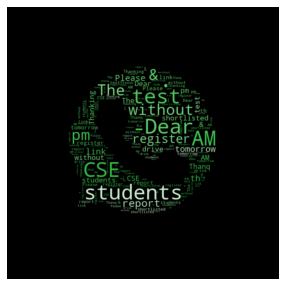

In [19]:
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator

img_mask = np.array(PIL.Image.open("wanalyzer.png"))
image_colors = ImageColorGenerator(img_mask)

wordcloud = WordCloud(background_color = 'black',mask = img_mask,random_state=1,repeat=True)
wordcloud.fit_words(frequencies=frequent_words)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()